# Predizendo Espécies de Abelhas a partir de Imagens

## Introdução

<center>

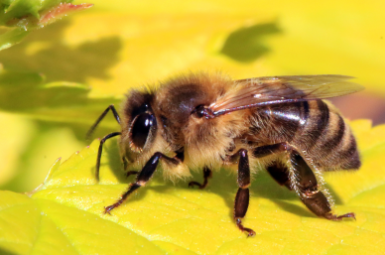

Uma máquina pode identificar uma abelha como melífera (*Apis*) ou mangangá (*Bombus*)? Estas abelhas têm comportamentos e aparências diferentes, mas dada a variedade de fundos, posições e resoluções de imagem, pode ser um desafio para as máquinas diferenciá-las.

Ser capaz de identificar espécies de abelhas a partir de imagens é uma tarefa que, em última análise, permitiria aos pesquisadores coletar dados de campo de forma mais rápida e eficaz. As abelhas polinizadoras têm papéis críticos tanto na ecologia como na produção de mel e soja, e doenças como o [distúrbio do colapso das colónias](https://www.bbc.com/portuguese/brasil-49657447) ameaçam estas espécies. A identificação de diferentes espécies de abelhas na natureza significa que podemos compreender melhor a prevalência e o crescimento destes importantes insetos.

## Adquirindo Recursos

Em primeiro lugar precisamos importar as bibliotecas usadas para a leitura e processamento dos dados. E assim que for feita uma observação do conteúdo disposto é feito o polimento aos dados direcinado para o modelo preditivo.

In [ ]:
# Runned on GoogleColab

# Used to change filepaths
import os

# Basic data manipulation and visualization
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Image manipulation
from PIL import Image
from skimage.feature import hog
from skimage.color import rgb2gray

# Data processing functions
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Data split for train and test
from sklearn.model_selection import train_test_split

# Model used
from sklearn.svm import SVC

# Metrics used
from sklearn.metrics import roc_curve, auc, accuracy_score

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report

In [ ]:
import requests, zipfile, io

zip_file_url = 'https://github.com/Oliveira-Caique/Data-Science/raw/main/Abelhas-Afora-Predizendo-Especies-a-partir-de-Imagens/datasets/images.zip'
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))

! mkdir images
image_path = "/content/images/" # /content folder is default on GoogleColab

z.extractall(image_path)

In [ ]:
# load the labels using pandas
url = 'https://raw.githubusercontent.com/Oliveira-Caique/Data-Science/main/Abelhas-Afora-Predizendo-Especies-a-partir-de-Imagens/datasets/labels.csv'
labels = pd.read_csv(url, index_col=0)

# show ramdom five rows of the label dataframe
display(labels.sample(5))

# show the quantity of each label
print()
print("Qtt of labels:")
display(labels.value_counts())

,genus
id,
4548,0.0
4099,0.0
2330,0.0
2983,1.0
3639,1.0



Qtt of labels:


genus
0.0      250
1.0      250
dtype: int64

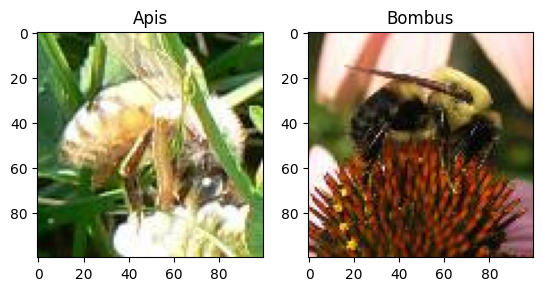

In [ ]:
def get_image(row_id, root=image_path):
    """
    Converts an image number into the file path where the image is located,
    opens the image, and returns the image as a numpy array.
    """

    filename = "{}.jpg".format(row_id)
    file_path = os.path.join(root, filename)
    img = Image.open(file_path)

    return img

# subset the dataframe to just Apis (genus is 0.0) get the value of the sixth item in the index
apis_row = labels[labels.genus == 0.0].index[0]

fig, ax = plt.subplots(1, 2)

# show the corresponding image of an Apis
ax[0].imshow(get_image(apis_row))
ax[0].set_title("Apis")

# subset the dataframe to just Bombus (genus is 1.0) get the value of the sixth item in the index
bombus_row = labels[labels.genus == 1.0].index[1]

# show the corresponding image of a Bombus
ax[1].imshow(get_image(bombus_row))
ax[1].set_title("Bombus")

plt.show()

## Extração de Características

Já que o conjunto de dados anterior consta de imagens com as mesmas dimensões (100x100), o que evita desbalanceamento de informações, e 250 amostras de cada espécie, o que garante a proporção dos conjuntos de treino e teste do modelo. Segue-se então para a extração das entradas.

Uma vez que o modelo escolhido, nesse caso a *Suport Vector Machine* (SVM) o Máquina de Vetores de Suporte não lida bem com as informações em formato matricial de pixels, como as imagens são dispostas, é feita a coleta das principais infomações conforme os passos abaixo:
1. Conversão da imagem para preto e branco, afim de receber uma matriz de duas dimenções oa invés de três com as componentes de cor RGB
2. Conversão da imagem em um histograma de gradientes orientados, que uma forma de descrever figuras pelo seu delineado e diferença na iluminação
3. Criar e nivelar características em uma lista de uma dimensão

Depois de estabelecidos esses passos são agregados em uma função para estabelecer as entradas da SVM com base no conjunto de imagens anterior.

Text(0.5, 1.0, 'Greyscale Image Shape: (100, 100)')

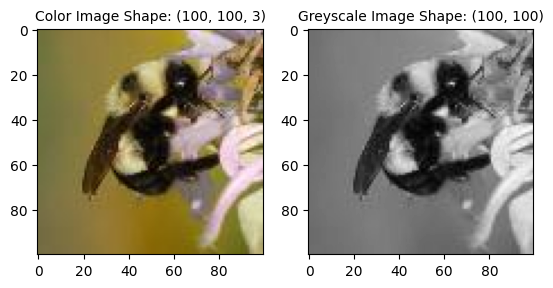

In [ ]:
# 1

# load a bombus image using our get_image function
bombus_row = labels[labels.genus == 1.0].index[5]

fig, ax = plt.subplots(1, 2)

bombus = get_image(bombus_row)
bombus = np.array(bombus)

# convert the bombus image to grayscale
gray_bombus = rgb2gray(bombus)

ax[0].imshow(bombus)
ax[0].set_title("Color Image Shape: "+ str(bombus.shape),
                size = 10)

# show the grayscale image
ax[1].imshow(gray_bombus, cmap='gray')
ax[1].set_title("Greyscale Image Shape: "+ str(gray_bombus.shape),
                size = 10)


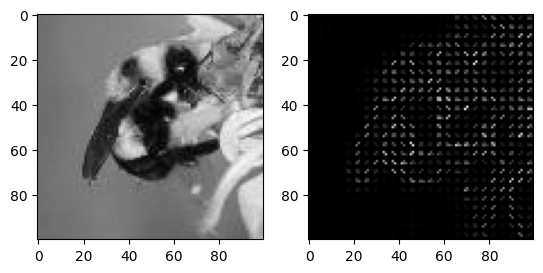


Image pixel values:
[[0.42843451 0.42843451 0.42786902 ... 0.69650392 0.59454314 0.62199412]
 [0.42843451 0.42843451 0.42786902 ... 0.76427961 0.78949059 0.56035804]
 [0.42957333 0.42957333 0.42786902 ... 0.57547176 0.6004     0.31272667]
 ...
 [0.41748745 0.42140902 0.42335843 ... 0.69921529 0.65607804 0.63254863]
 [0.41748745 0.42140902 0.42335843 ... 0.68745059 0.65999961 0.6482349 ]
 [0.41748745 0.42140902 0.42335843 ... 0.68352902 0.67568588 0.67568588]]

HoG features data:
[0.23381163 0.         0.         ... 0.02680987 0.02110059 0.        ]


In [ ]:
# 2

# run HOG using our grayscale bombus image
hog_features, hog_image = hog(gray_bombus,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(4, 4))

fig, ax = plt.subplots(1, 2)

ax[0].imshow(gray_bombus, cmap='gray')

# show our hog_image with a gray colormap
ax[1].imshow(hog_image, cmap='gray')

plt.show()

print()
print("Image pixel values:")
print(gray_bombus)

print()
print("HoG features data:")
print(hog_features)


In [ ]:
# 3

def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()

    # convert image to grayscale
    gray_image = rgb2gray(img)

    # get HOG features from grayscale image
    hog_features = hog(gray_image, block_norm='L2-Hys',
                       pixels_per_cell=(16, 16))

    # combine color and hog features into a single array
    flat_features = np.hstack((color_features, hog_features))

    return flat_features

bombus_features = create_features(bombus)

# print shape of bombus_features
print("Bombus features:")
print(bombus_features)
print()

print("Bombus features shape:")
print(bombus_features.shape)

Bombus features:
[1.13000000e+02 1.13000000e+02 6.10000000e+01 ... 1.87603900e-02
 2.22107217e-01 1.74864236e-01]

Bombus features shape:
(31296,)


In [ ]:
def create_feature_matrix(label_dataframe):
    features_list = []

    for img_id in label_dataframe.index:
        # load image
        img = get_image(img_id)
        #convert to numpy array
        img = np.array(img)
        # get features for image
        image_features = create_features(img)
        features_list.append(image_features)

    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(labels)

print("(N of instances, N of features):")
print(feature_matrix.shape)

(N of instances, N of features):
(500, 31296)


## Processando as Entradas

Agora é preciso dividir as entradas entre treino(70%), para calibrar o modelo e teste(30%) para verificar a eficiência do mesmo.


In [ ]:
# split the data into training and test sets

X = feature_matrix
y = labels.genus.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1234123)

# look at the distribution of labels in the train set
print("Train Label counts:")
print(pd.Series(y_train).value_counts())
print()

print("Test Label counts:")
print(pd.Series(y_test).value_counts())

Train Label counts:
1.0    175
0.0    175
dtype: int64

Test Label counts:
0.0    75
1.0    75
dtype: int64


Os recursos ainda não estão prontos. Muitos métodos de aprendizado de máquina são desenvolvidos para funcionar melhor com dados que têm média zero e variação unitária.

Precisa-se dividir esses dados antes de dimensionar para evitar vazamento de dados, onde o modelo obtém informações sobre o conjunto de teste.

In [ ]:
# define standard scaler
ss = StandardScaler()

# fit the scaler and transform the training features
train_stand = ss.fit_transform(X_train)

# transform the test features
test_stand = ss.transform(X_test)

# look at the new shape of the standardized feature matrices
print('Standardized training features matrix shape is: ', train_stand.shape)

print('Standardized test features matrix shape is: ', test_stand.shape)

Standardized training features matrix shape is:  (350, 31296)
Standardized test features matrix shape is:  (150, 31296)


Temos mais de 31.000 características para cada imagem e apenas 500 imagens no total. Para melhorar o desempenho de uma SVM, o modelo escolhido, também precisamos reduzir o número de entradas usando a [análise de componentes principais](https://www.section.io/engineering-education/image-compression-using-pca/) (em inglês, PCA). A grosso modo, PCA  é um conjunto de operações matemáticas que reduz as caracteríticas do conjunto de dados selecionando aquelas que mais informam sobre a variabilidade dos dados.

Neste caso, são mantidos 350 componentes, que é a quanddade de instâncias do nosso grupo de treino, dado que o "encaixe" dessa análise/redução deve retornar uma matriz quadrada. Isso significa que nossas matrizes de recursos train_stand e test_stand terão apenas 350 colunas, em vez do original de 31.296.

In [ ]:
# Instantiate a PCA object with 350 components
pca = PCA(n_components = 350)

# use fit_transform on our standardized training features
X_train = pca.fit_transform(train_stand)

# use transf
X_test = pca.transform(test_stand)

# look at new shape
print('Training features matrix is: ', X_train.shape)
print('Test features matrix is: ', X_test.shape)

Training features matrix is:  (350, 350)
Test features matrix is:  (150, 350)


## Treinando

Um modelo SVM é uma representação dos exemplos como pontos no espaço, mapeados de modo que os exemplos das categorias separadas sejam divididos por uma lacuna clara e tão ampla quanto possível. Novos exemplos são então mapeados nesse mesmo espaço e previstos como pertencentes a uma categoria com base no lado da lacuna em que se enquadram.

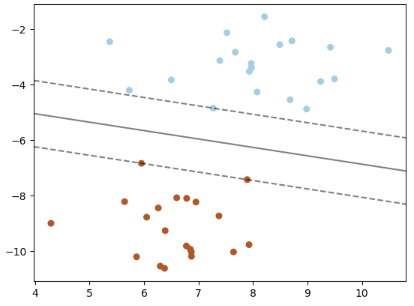

In [ ]:
# define support vector classifier
svm = SVC(kernel='linear', probability = True, random_state = 42)

# fit model
svm.fit(X_train, y_train)

print("Qtt of instances used as support vector:", len(svm.support_))

Qtt of instances used as support vector: 316


## Predição

### Acurácia

Agora o conjunto de teste é usado para verificar a proporção de acertos do modelo.

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# generate predictions
y_pred = svm.predict(X_test)

pd.DataFrame({"Predicted": y_pred[:5], "Real":y_test[:5]})

,Predicted,Real
0,1.0,0.0
1,1.0,1.0
2,1.0,1.0
3,0.0,0.0
4,0.0,0.0


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

cm = pd.DataFrame({"True": [tp, tn], "False": [fp, fn]})
cm['result'] = ["Positive", "Negative"]
cm = cm.set_index('result')
cm

,True,False
result,,
Positive,49,21
Negative,54,26


$
\displaystyle
\text{accuracy} =
\frac{\text{tp}+\text{tn}}{\text{tp}+\text{tn}+\text{fp}+\text{fn}}
$

In [ ]:
# calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print('Model accuracy is: {:f}'.format(accuracy))
# (tp + tn)/(tp + tn + fp + fn)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.68      0.72      0.70        75
         1.0       0.70      0.65      0.68        75

    accuracy                           0.69       150
   macro avg       0.69      0.69      0.69       150
weighted avg       0.69      0.69      0.69       150



Obtemos então um modelo com quase 70% de acurácia! Entretanto, é possível ainda averiguar o quão bom o modelo é de fato em comparação com uma preditor aleatório.

### Curva ROC e AUC

Complementamos então a medida anterior pelo seguinte raciocínio, "para a primeira imagem, o que significa que há 46% de chance de a abelha na imagem ser uma Apis (0,0) e 53% de chance de a abelha na imagem ser uma Bombus (1,0)."

In [ ]:
# predict probabilities for X_test using predict_proba
probabilities = svm.predict_proba(X_test)

probabilities[0]

array([0.46334056, 0.53665944])

Usando as configurações padrão, as probabilidades de 0,5 ou superiores recebem um rótulo de classe de 1,0 e aquelas abaixo recebem um rótulo de 0,0. No entanto, este limite pode ser ajustado. A curva característica de operação do receptor (en inglês *ROC curve*) representa graficamente a taxa de falsos positivos e a taxa de verdadeiros positivos em diferentes limites. As curvas ROC são avaliadas visualmente pela proximidade com o canto superior esquerdo.

A área sob a curva (em inglês *AUC*) também é calculada, onde 1 significa que todos os rótulos previstos estavam corretos. Geralmente, a pior pontuação para AUC é 0,5, que no caso é o desempenho de um modelo que adivinha aleatoriamente."

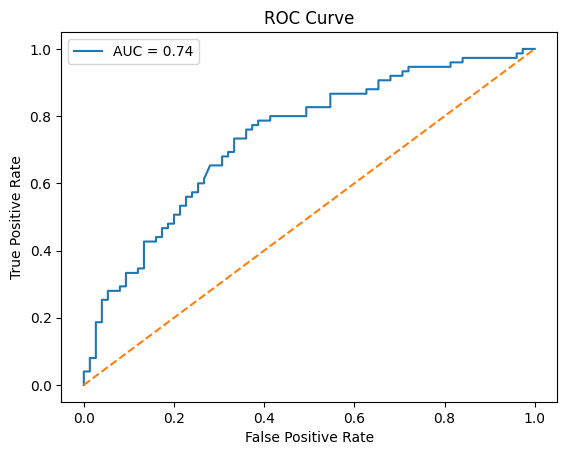

In [ ]:
# select the probabilities for label 1.0
y_proba = probabilities[:,1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('ROC Curve')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

A área abiaxo da curva tem valor 0.74! O que é bom, uma vez que confirma a legitimidade dessa abordagem de forma precisa.

# Ajuste de Hyperparametros

## Grid Search

Avaliação de diferentes parametros para o modelo, testando possíveis combinações de valores.

In [ ]:
new_svm = SVC(probability = True)

params = {"C": [0.0000001, 0.00001, 0.001, 0.01, 0.1, 1, 10],
          "gamma":[0.01, 0.1, 1, 10],
          "kernel":["linear", "rbf", "poly", "sigmoid"],
          }

kf = KFold(n_splits = 3, random_state = 42, shuffle = True)

searcher = GridSearchCV(new_svm, params, cv = kf)

searcher.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=SVC(probability=True),
             param_grid={'C': [1e-07, 1e-05, 0.001, 0.01, 0.1, 1, 10],
                         'gamma': [0.01, 0.1, 1, 10],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']})

In [ ]:
print(searcher.best_params_)
print(searcher.best_score_)

{'C': 0.001, 'gamma': 0.01, 'kernel': 'linear'}
0.5944100599273013


In [ ]:
y_pred = searcher.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.68      0.72      0.70        75
         1.0       0.70      0.65      0.68        75

    accuracy                           0.69       150
   macro avg       0.69      0.69      0.69       150
weighted avg       0.69      0.69      0.69       150



Com métricas não muito diferentes do primeiro modelo, esse processo é descartado.

## Ensemble

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
ada_svc = AdaBoostClassifier(estimator=new_svm,
                             n_estimators=300,
                             random_state=1)

ada_svc.fit(X_train, y_train)

AdaBoostClassifier(estimator=SVC(probability=True), n_estimators=300,
                   random_state=1)

In [ ]:
y_pred = ada_svc.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.67      0.48      0.56        75
         1.0       0.59      0.76      0.67        75

    accuracy                           0.62       150
   macro avg       0.63      0.62      0.61       150
weighted avg       0.63      0.62      0.61       150



Ao fazer uso de modelos compostos, no caso, com AdaBoost houve uma redução da acurácia, assim, essa técnica também será desconsiderada...

## XGBoost

XGBoost parece ser um algoritmo muito famoso e geralmente eficaz em variadas resoluções de problema.

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgboost = XGBClassifier()

In [ ]:
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = xgboost.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.60      0.69      0.65        75
         1.0       0.64      0.55      0.59        75

    accuracy                           0.62       150
   macro avg       0.62      0.62      0.62       150
weighted avg       0.62      0.62      0.62       150



Também houve uma queda no desempenho para XGBoost em comparação com o modelo inicial.

# Considerações finais

Assim, o modelo escolhido, SVM, demonstrou um desempenho satisfatório na tarefa de classificação das espécies de abelhas Bombus e Apis. Ainda que, usando uma abordagem relativamente simples, suas métricas de desempenho superaram aquelas obtidas por métodos usualmente considerados mais robustos, tais como GridSearch, ensemble e XGBoost.